In [ ]:
# importing library
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding,SpatialDropout1D,LSTM,Dense
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [ ]:
# Load the data
df = pd.read_csv('Tweets.csv')

In [ ]:
# top 5 rows
df.head()

,tweet_id,sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,candidate,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2/24/2015 11:35,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2/24/2015 11:15,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2/24/2015 11:15,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2/24/2015 11:15,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2/24/2015 11:14,NaN,Pacific Time (US & Canada)


In [ ]:
# Filter relevant columns
df_relevant = df[['candidate', 'sentiment', 'text']]
df_relevant.head()

,candidate,sentiment,text
0,cairdin,neutral,@VirginAmerica What @dhepburn said.
1,jnardino,positive,@VirginAmerica plus you've added commercials t...
2,yvonnalynn,neutral,@VirginAmerica I didn't today... Must mean I n...
3,jnardino,negative,@VirginAmerica it's really aggressive to blast...
4,jnardino,negative,@VirginAmerica and it's a really big bad thing...


<Axes: ylabel='count'>

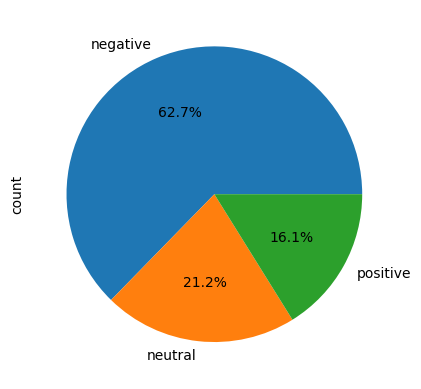

In [ ]:
# Sentiment
df_relevant['sentiment'].value_counts().plot.pie(autopct='%1.1f%%')

In [ ]:
# Download the 'stopwords' dataset
nltk.download('stopwords')

# Download the 'punkt' dataset
!pip install nltk
import nltk
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
# Text preprocessing function
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()  # Converting to lowercase
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)  # Removing URLs
    text = re.sub(r'\@\w+|\#', '', text)  # Removing mentions and hashtags
    text = re.sub(r'[^\w\s]', '', text)  # Removing punctuation
    tokens = word_tokenize(text)  # Tokenize
    filtered_words = [word for word in tokens if word not in stop_words]  # Removing stop words
    return ' '.join(filtered_words)

In [ ]:
df_relevant['cleaned_text'] = df_relevant['text'].apply(clean_text)

<ipython-input-113-16ca0c216c8a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_relevant['cleaned_text'] = df_relevant['text'].apply(clean_text)


In [ ]:
# drop text columns
df_relevant.drop('text', axis=1, inplace=True)
df_relevant.head()

<ipython-input-114-8e4574c0c23c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_relevant.drop('text', axis=1, inplace=True)


,candidate,sentiment,cleaned_text
0,cairdin,neutral,said
1,jnardino,positive,plus youve added commercials experience tacky
2,yvonnalynn,neutral,didnt today must mean need take another trip
3,jnardino,negative,really aggressive blast obnoxious entertainmen...
4,jnardino,negative,really big bad thing


In [ ]:
# Tokenization
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(df_relevant['cleaned_text'])
sequences = tokenizer.texts_to_sequences(df_relevant['cleaned_text'])

# Padding sequences
max_length = 100
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')

In [ ]:
# Model Building
model = Sequential()
model.add(Embedding(input_dim=5000,output_dim=128,input_length=max_length))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(100,dropout=0.2,recurrent_dropout=0.2))
model.add(Dense(3,activation='softmax'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [ ]:
# Compile the model
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
# Convert Sentiment label to numerical format
label_mapping = {'positive':0, 'negative':1, 'neutral':2}
label = df_relevant['sentiment'].map(label_mapping)

In [ ]:
# Splitting the data
x_train,x_val,y_train,y_val = train_test_split(padded_sequences,label,test_size=0.2,random_state=42)

In [ ]:
# Convert to one-hot encoded format
y_train = to_categorical(y_train, num_classes=3)
y_val = to_categorical(y_val, num_classes=3)

In [ ]:
# Train the model
history = model.fit(x_train, y_train, epochs=10, batch_size=64, validation_data=(x_val, y_val), verbose=1)

Epoch 1/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 63s 329ms/step - accuracy: 0.6095 - loss: 0.9430 - val_accuracy: 0.6452 - val_loss: 0.8953
Epoch 2/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 38s 209ms/step - accuracy: 0.6182 - loss: 0.9323 - val_accuracy: 0.6452 - val_loss: 0.8952
Epoch 3/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 41s 225ms/step - accuracy: 0.6208 - loss: 0.9270 - val_accuracy: 0.6452 - val_loss: 0.8993
Epoch 4/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 81s 218ms/step - accuracy: 0.6215 - loss: 0.9254 - val_accuracy: 0.6452 - val_loss: 0.8952
Epoch 5/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 40s 217ms/step - accuracy: 0.6243 - loss: 0.9215 - val_accuracy: 0.6452 - val_loss: 0.8964
Epoch 6/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 40s 214ms/step - accuracy: 0.6232 - loss: 0.9214 - val_accuracy: 0.6452 - val_loss: 0.8971
Epoch 7/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 39s 201ms/step - accuracy: 0.6176 - loss: 0.9296 - val_accuracy: 0.6452 - val_loss: 0.8949
Epoch 8/10
183/183 ━━━━━━━━━━━━━━━━━━━━ 39s 213ms/step - accuracy: 0.6245 - loss: 0

In [ ]:
# Predict sentiment for the test set
predictions = model.predict(x_val)

# Convert predicted probabilities to class labels (0, 1, 2)
predicted_classes = predictions.argmax(axis=1)

# If y_test is still one-hot encoded, convert it back to label format for comparison
true_classes = y_val.argmax(axis=1)

# Example: Display first 5 predicted vs true labels
for i in range(5):
    print(f"Tweet: {x_val[i]} | Predicted Sentiment: {predicted_classes[i]} | True Sentiment: {true_classes[i]}")


92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step
Tweet: [ 139  262 3706  118   37 3707    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0] | Predicted Sentiment: 1 | True Sentiment: 0
Tweet: [ 175  345    4   27  158 1754  398  481   19   53    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0  